# Basketball Playoffs Qualification

## Task description

Basketball tournaments are usually split in two parts. First, all teams play each other aiming to achieve the greatest number of wins possible. Then, at the end of the first part of the season, a pre determined number of teams which were able to win the most games are qualified to the playoff season, where they play series of knock-out matches for the trophy.

For the 10 years, data from players, teams, coaches, games and several other metrics were gathered and arranged on this dataset. The goal is to use this data to predict which teams will qualify for the playoffs in the next season.

## Data preparation

### Creating the database

First, we need to convert the CSV files to tables in an SQLite database, so we can analyze, manipulate and prepare data more easily. This was done with a couple of SQlite3 commands:

```
.mode csv
.import dataset/awards_players.csv awards_players
.import dataset/coaches.csv coaches
.import dataset/players.csv players
.import dataset/players_teams.csv players_teams
.import dataset/series_post.csv series_post
.import dataset/teams_post.csv teams_post
.import dataset/teams.csv teams
.save database.db
```

### Filtering unneeded rows and columns

Upon closer inspection of the dataset, we found some rows which had no effect or could have a negative impact in our models training, such as rows in the players table which corresponded to current coaches, and thus had no information related to their height, weight, etc.

## Model performance measures

### The Game Score measure
The Game Score measure, created by John Hollinger, attempts to give an estimation of a player's productivity for a single game. We will start working on our model based on this measure, applying it to each player based on a whole season's stats and dividing it by the amount of games played.


## Data Preparation and Metrics

Import necessary packages

In [145]:
import sqlite3
import pandas as pd

Create dataframes based on the database and relations between data

In [146]:
con = sqlite3.connect("database.db")

# Player <-> Awards
pl_aw = pd.read_sql_query('''
    SELECT players_teams.playerID, players_teams.tmID,
        awards_players.award, awards_players.year
    FROM awards_players 
    LEFT JOIN players_teams
    ON (
        awards_players.playerID = players_teams.playerID 
        AND awards_players.year = players_teams.year
    )''', con)

# Coach <-> Awards
cc_aw = pd.read_sql_query('''
        SELECT playerID, award, c.year, c.tmID
        FROM awards_players
        INNER JOIN
        (
                SELECT coaches.coachID, teams.year,
                    coaches.year, teams.tmID
                FROM teams
                INNER JOIN coaches
                ON (
                    coaches.tmID = teams.tmID
                    AND coaches.year = teams.year
                )    
        ) AS c
        ON (
            awards_players.playerID = c.coachID
            AND awards_players.year = c.year
        )
    ''', con)

# Players
pl = pd.read_sql_query("SELECT * FROM players", con)

# Platyer Teams
pt = pd.read_sql_query("SELECT * FROM players_teams", con)

# Player <-> Teams
pl_tm = pd.read_sql_query("SELECT * FROM players_teams INNER JOIN players ON players_teams.playerID = players.bioID", con)

# Teams <-> Post Season Results (aggregated)
tm_psa = pd.read_sql_query('''
    SELECT teams.year, teams.lgID, teams.tmID, franchID,
       confID, divID, rank, playoff, seeded, firstRound, semis,
       finals, name, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa,
       o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk,
       o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb,
       d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts,
       tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB, won,
       lost, GP, homeW, homeL, awayW, awayL, confW, confL,
       min, attend, arena,W, L
    FROM teams_post 
    INNER JOIN teams 
    ON (
        teams_post.tmID = teams.tmID 
        AND teams_post.year = teams.year
    )''', con)

# Coach <-> Teams
cc_tm = pd.read_sql_query("SELECT * FROM coaches INNER JOIN teams ON (coaches.tmID = teams.tmID AND coaches.year = teams.year)", con)

# Teams <-> Post Series Results
tm_pss = pd.read_sql_query('''
    SELECT winners.winnersID, winners.year, winners.winnersPlayoff, winners.winnersRank, losers.tmID, losers.playoff, losers.rank
    FROM
    (
        SELECT teams.tmID AS winnersID, teams.year AS year, teams.playoff AS winnersPlayoff, teams.rank AS winnersRank, series_post.tmIDLoser AS tmIDLoser
        FROM series_post 
        INNER JOIN teams
        ON
        (series_post.tmIDWinner = teams.tmID AND series_post.year = teams.year)
    ) AS winners
    JOIN teams AS losers
    ON
    (winners.tmIDLoser = losers.tmID AND winners.year = losers.year)
''', con)
cc_aw

,playerID,award,year,tmID
0,coopemi01w,Coach of the Year,1,LAS
1,hugheda99w,Coach of the Year,2,CLE
2,stanlma99w,Coach of the Year,3,WAS
3,laimbbi01w,Coach of the Year,4,DET
4,mcconsu01w,Coach of the Year,5,MIN
5,whisejo99w,Coach of the Year,6,SAC
6,thibami99w,Coach of the Year,7,CON
7,hugheda99w,Coach of the Year,8,SAS
8,thibami99w,Coach of the Year,9,CON
9,meadoma99w,Coach of the Year,10,ATL


## Data Pre-processing

### Column dropping

First, remove columns that only have null values or no unique values.

In [147]:
dataframes = [pl, pl_tm, tm_psa, cc_tm]

for i in range(len(dataframes)):
    unique_counts = dataframes[i].nunique()
    dropped_columns = dataframes[i].columns[(dataframes[i].isna().sum() == len(dataframes[i])) | (unique_counts == 1)]
    
    print(f"Dropped columns in dataframe {i}: {list(dropped_columns)}")
    
    dataframes[i] = dataframes[i].drop(columns=dropped_columns, axis=1, inplace=True)

Dropped columns in dataframe 0: ['firstseason', 'lastseason']
Dropped columns in dataframe 1: ['lgID', 'firstseason', 'lastseason']
Dropped columns in dataframe 2: ['lgID', 'divID', 'playoff', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']
Dropped columns in dataframe 3: ['lgID', 'lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']


Now, we remove Player rows that have birth-date `0000-00-00`.

In [148]:
pl = pl.drop(pl[pl['birthDate'] == '0000-00-00'].index, axis = 0)
pl_tm = pl_tm.drop(pl_tm[pl_tm['birthDate'] == '0000-00-00'].index, axis = 0)

Lastly, when applicable, we remove the Team `name` attribute, since we already have access to the `tmID`.

In [149]:
tm_psa = tm_psa.drop(['name'], axis=1)
cc_tm = cc_tm.drop(['name'], axis=1)

### Categorical encoding of Awards

Since not all awards are equal, it's useful to attribute each one a score, to signal to the algorithms the relevance each one has. For example, the `All-Star Game Most Valuable Player` is the most valuable one, while the `Kim Perrot Sportsmanship Award` is attributed only to those who show sportsmanship, revealing no real playing skill.

In [150]:
print(pl_aw['award'].unique())

['All-Star Game Most Valuable Player' 'Coach of the Year'
 'Defensive Player of the Year' 'Kim Perrot Sportsmanship'
 'Kim Perrot Sportsmanship Award' 'Most Improved Player'
 'Most Valuable Player' 'Rookie of the Year' 'Sixth Woman of the Year'
 'WNBA Finals Most Valuable Player' 'WNBA All-Decade Team'
 'WNBA All Decade Team Honorable Mention']


As we can see the `Kim Perrot Sportsmanship Award` has two possible values, so we merge those two, before encoding the awards.

In [151]:
pl_aw['award'] = pl_aw['award'].replace(['Kim Perrot Sportsmanship', 'Kim Perrot Sportsmanship Award'], 'Kim Perrot Sportsmanship Award')

print(pl_aw['award'].unique())

['All-Star Game Most Valuable Player' 'Coach of the Year'
 'Defensive Player of the Year' 'Kim Perrot Sportsmanship Award'
 'Most Improved Player' 'Most Valuable Player' 'Rookie of the Year'
 'Sixth Woman of the Year' 'WNBA Finals Most Valuable Player'
 'WNBA All-Decade Team' 'WNBA All Decade Team Honorable Mention']


We can rank the awards as follows:

| Award                                    | Score |
|------------------------------------------|-------|
| 'All-Star Game Most Valuable Player'     |    7  |
| 'Coach of the Year'                      |   10  |
| 'Defensive Player of the Year'           |    7  |
| 'Kim Perrot Sportsmanship Award'         |    3  |
| 'Most Improved Player'                   |    8  |
| 'Most Valuable Player'                   |   10  |
| 'Rookie of the Year'                     |    8  |
| 'Sixth Woman of the Year'                |    7  |
| 'WNBA Finals Most Valuable Player'       |    7  |
| 'WNBA All-Decade Team'                   |    4  |
| 'WNBA All Decade Team Honorable Mention' |    3  |

In [152]:
award_scores = {
    'All-Star Game Most Valuable Player': 7,
    'Coach of the Year': 10,
    'Defensive Player of the Year': 7,
    'Kim Perrot Sportsmanship Award': 3,
    'Most Improved Player': 8,
    'Most Valuable Player': 10,
    'Rookie of the Year': 8,
    'Sixth Woman of the Year': 7,
    'WNBA Finals Most Valuable Player': 7,
    'WNBA All-Decade Team': 4,
    'WNBA All Decade Team Honorable Mention': 3
}

pl_aw['award_score'] = pl_aw['award'].map(award_scores)
cc_aw['award_score'] = cc_aw['award'].map(award_scores)

print(pl_aw)
print(cc_aw)


      playerID  tmID                                   award year  award_score
0   thompti01w   HOU      All-Star Game Most Valuable Player    1            7
1   leslili01w   LAS      All-Star Game Most Valuable Player    2            7
2   leslili01w   LAS      All-Star Game Most Valuable Player    3            7
3   teaslni01w   LAS      All-Star Game Most Valuable Player    4            7
4   swoopsh01w   HOU      All-Star Game Most Valuable Player    6            7
..         ...   ...                                     ...  ...          ...
90        None  None  WNBA All Decade Team Honorable Mention    7            3
91  holdsch01w   LAS  WNBA All Decade Team Honorable Mention    7            3
92  penicti01w   SAC  WNBA All Decade Team Honorable Mention    7            3
93  tauradi01w   PHO  WNBA All Decade Team Honorable Mention    7            3
94        None  None  WNBA All Decade Team Honorable Mention    7            3

[95 rows x 5 columns]
     playerID              aw

Now, for the graphs of this metric:

In [153]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

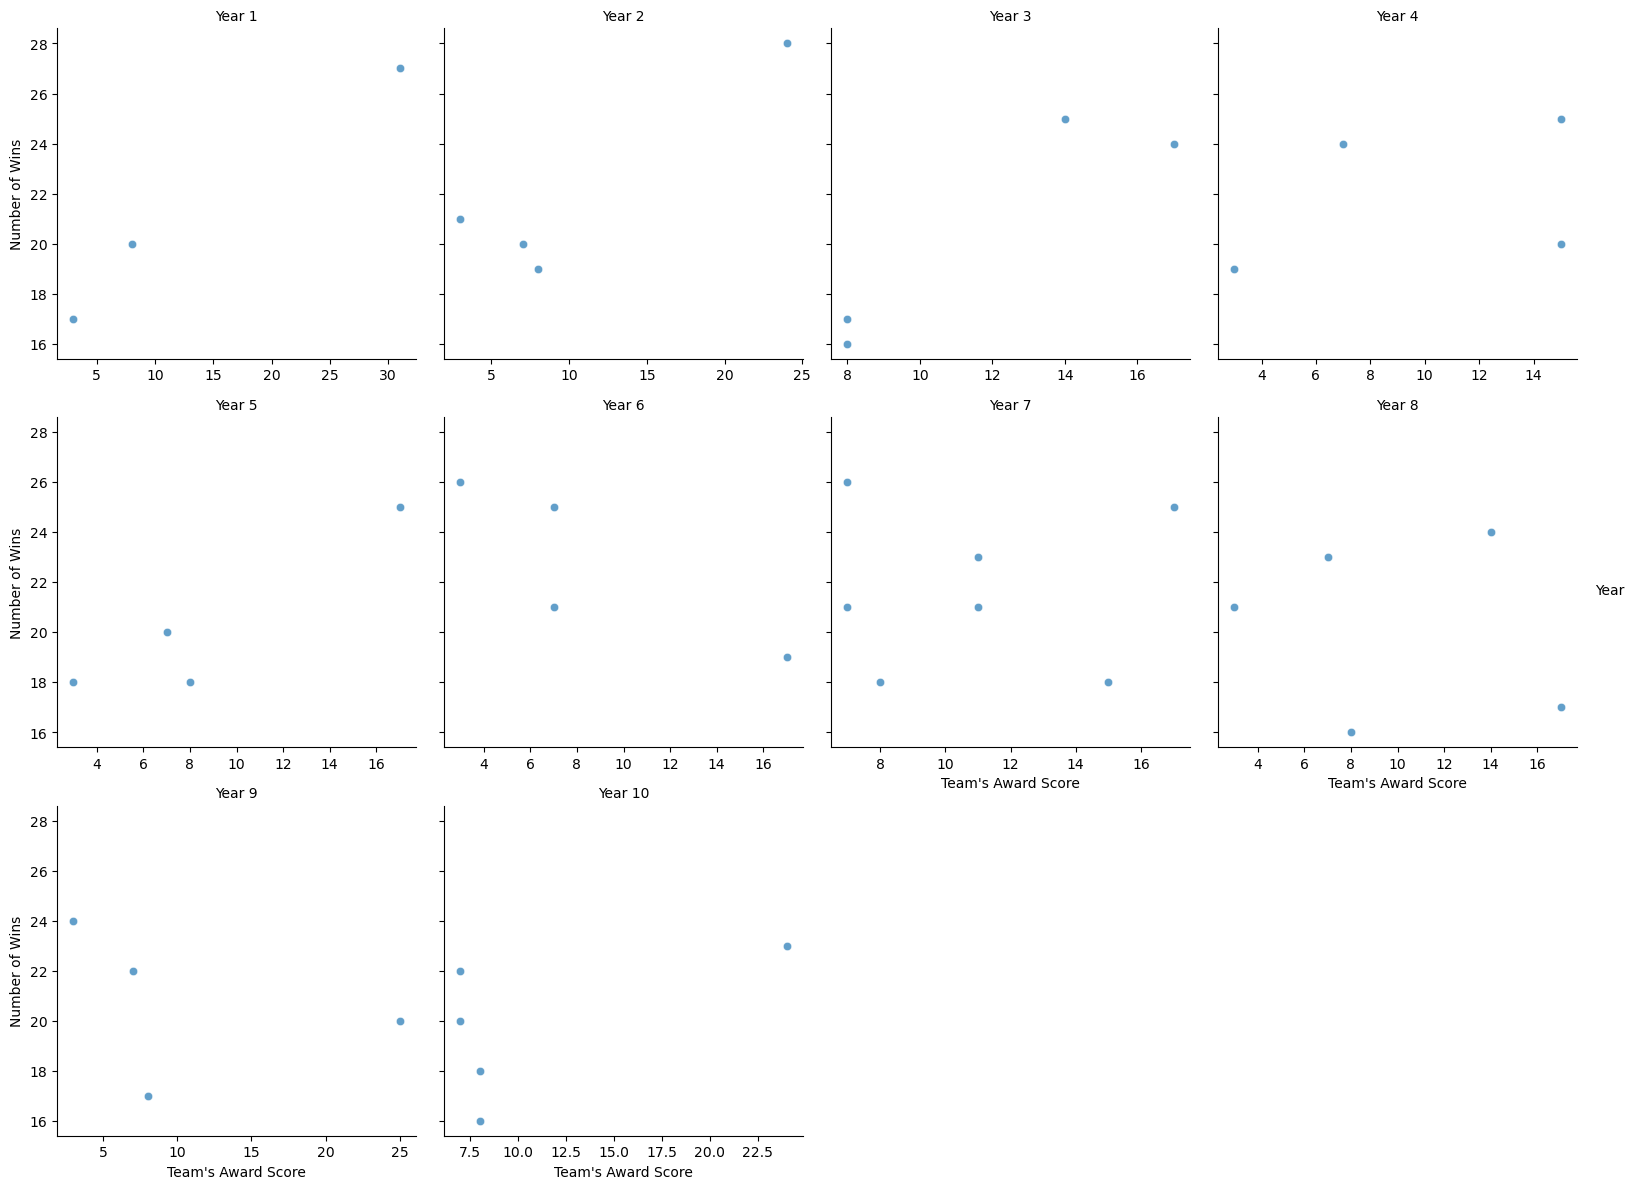

In [154]:
team_award_scores = pl_aw.groupby(['tmID', 'year'])['award_score'].sum().reset_index()

# Merge team award scores with team wins
merged_team_data = pd.merge(team_award_scores, tm_psa[['tmID', 'year', 'won']], on=['tmID', 'year'], how='left')
merged_team_data['year'] = pd.to_numeric(merged_team_data['year'])
merged_team_data.sort_values(by='year', inplace=True)

merged_team_data['award_score'] = pd.to_numeric(merged_team_data['award_score'])
merged_team_data['won'] = pd.to_numeric(merged_team_data['won'])

# Create a scatter plot with regression line for each year
g = sns.FacetGrid(merged_team_data, col="year", col_wrap=4, height=4, sharex=False)
g.map(sns.scatterplot, 'award_score', 'won', alpha=0.7)
#g.map(sns.regplot, 'award_score', 'won', scatter=False, color='red')  # Add regression line
g.set_axis_labels("Team's Award Score", "Number of Wins")
g.set_titles("Year {col_name}")
g.add_legend(title='Year')
plt.show()


### Outliers

Now, to analyse the `weight` and `height` attributes' Z-Score and IQR.

In [155]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

Height Z-Score
 0      0.49
1      0.49
2      0.97
3      0.25
4      0.73
       ... 
887   -0.47
888   -0.47
889    1.93
891   -0.71
892   -1.19
Name: height, Length: 809, dtype: float64

Weight Z-Score
 0      0.71
1      0.21
2      0.87
3      1.87
4      0.47
       ... 
887   -0.33
888   -0.12
889    2.23
891   -0.36
892   -0.29
Name: weight, Length: 809, dtype: float64


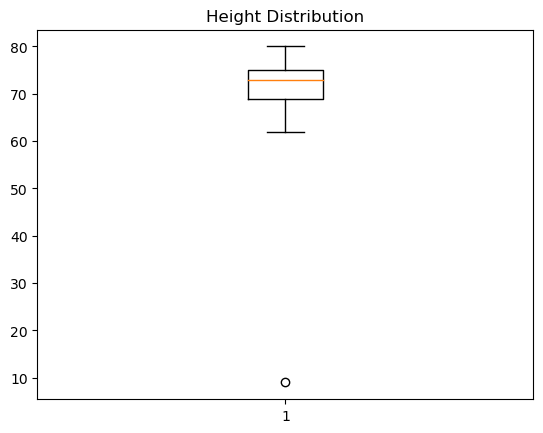

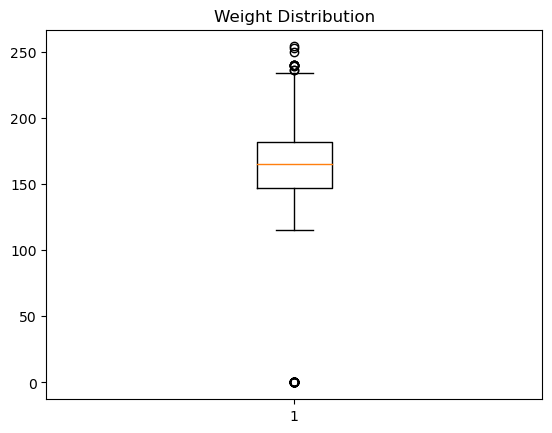

In [156]:
# Outliers for Player's Weight + Height

# Convert Height and Weight Columns into numeric values
pl['height'] = pd.to_numeric(pl['height'], errors='coerce')
pl['weight'] = pd.to_numeric(pl['weight'], errors='coerce')

pl_tm['height'] = pd.to_numeric(pl_tm['height'], errors='coerce')
pl_tm['weight'] = pd.to_numeric(pl_tm['weight'], errors='coerce')

pl = pl.dropna(subset=['height', 'weight'])
pl_tm = pl_tm.dropna(subset=['height', 'weight'])

height_zscores = stats.zscore(pl['height'])
weight_zscores = stats.zscore(pl['weight'])

# Plot boxplot
print("Height Z-Score\n", height_zscores)
print("\nWeight Z-Score\n", weight_zscores)

plt.title('Height Distribution')
plt.boxplot(pl['height'])
plt.show()

plt.title('Weight Distribution')
plt.boxplot(pl['weight'])
plt.show()

Team Played minutes Z-Score
 0    -1.39
1    -1.26
2    -1.26
3    -1.76
4    -1.64
      ... 
75    1.00
76    0.75
77    1.38
78    0.88
79    0.62
Name: min, Length: 80, dtype: float64


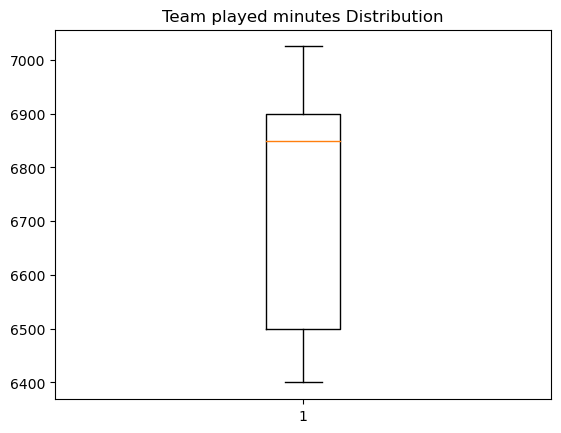

In [157]:
# Outlier for Team's played minutes

tm_psa['min'] = pd.to_numeric(tm_psa['min'], errors='coerce')
cc_tm['min'] = pd.to_numeric(cc_tm['min'], errors='coerce')

tm_psa = tm_psa.dropna(subset=['min'])
cc_tm = cc_tm.dropna(subset=['min'])


print("Team Played minutes Z-Score\n", stats.zscore(tm_psa['min']))
plt.title('Team played minutes Distribution')
plt.boxplot(tm_psa['min'])
plt.show()

Player Played minutes Z-Score
 0       0.96
1       0.84
2       0.81
3      -0.11
4       0.77
        ... 
1871   -1.29
1872   -0.25
1873    0.84
1874   -1.31
1875   -1.31
Name: minutes, Length: 1876, dtype: float64


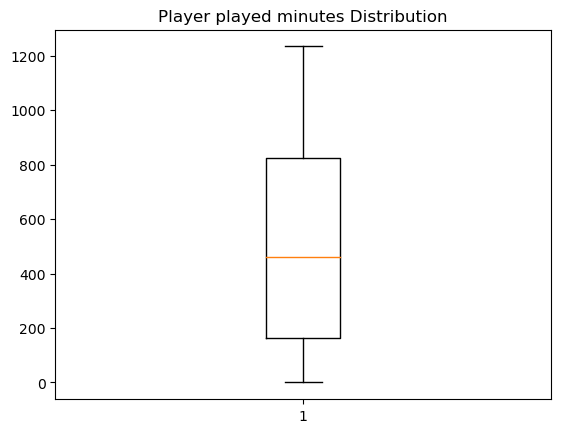

In [158]:
# Outlier for Player's played minutes

pl_tm['minutes'] = pd.to_numeric(pl_tm['minutes'], errors='coerce')

print("Player Played minutes Z-Score\n", stats.zscore(pl_tm['minutes']))
plt.title('Player played minutes Distribution')
plt.boxplot(pl_tm['minutes'])
plt.show()

Team's Offense Score Z-Score
 0     0.27
1    -0.91
2    -1.02
3    -1.06
4    -1.18
      ... 
75    0.90
76    3.30
77    0.58
78    0.53
79    0.76
Name: o_pts, Length: 80, dtype: float64


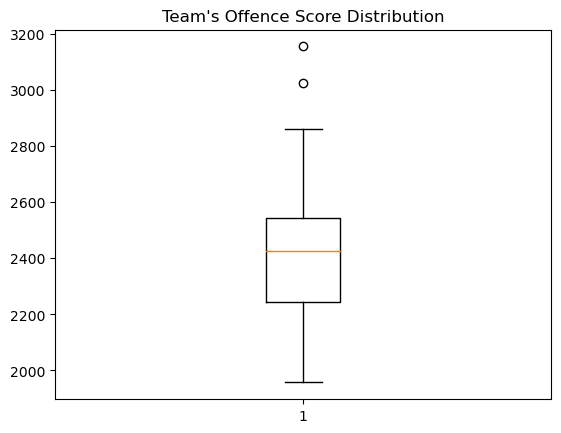

Team's Defense Score Z-Score
 0    -1.18
1    -0.44
2    -0.93
3    -0.49
4    -1.32
      ... 
75    1.46
76    3.10
77    0.64
78    0.73
79    1.28
Name: d_pts, Length: 80, dtype: float64


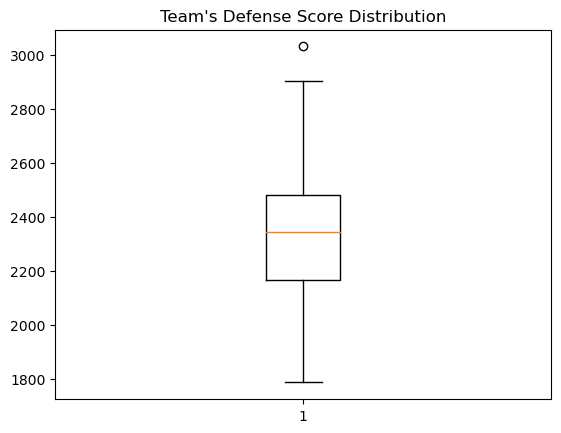

In [159]:
# Outlier Team points

tm_psa['o_pts'] = pd.to_numeric(tm_psa['o_pts'], errors='coerce')

print("Team's Offense Score Z-Score\n", stats.zscore(tm_psa['o_pts']))
plt.title("Team's Offence Score Distribution")
plt.boxplot(tm_psa['o_pts'])
plt.show()

tm_psa['d_pts'] = pd.to_numeric(tm_psa['d_pts'], errors='coerce')

print("Team's Defense Score Z-Score\n", stats.zscore(tm_psa['d_pts']))
plt.title("Team's Defense Score Distribution")
plt.boxplot(tm_psa['d_pts'])
plt.show()

Player's Scores Z-Score
 0       1.03
1       0.85
2       0.88
3      -0.19
4       0.79
        ... 
1871   -1.05
1872   -0.53
1873    1.42
1874   -1.02
1875   -1.03
Name: points, Length: 1876, dtype: float64


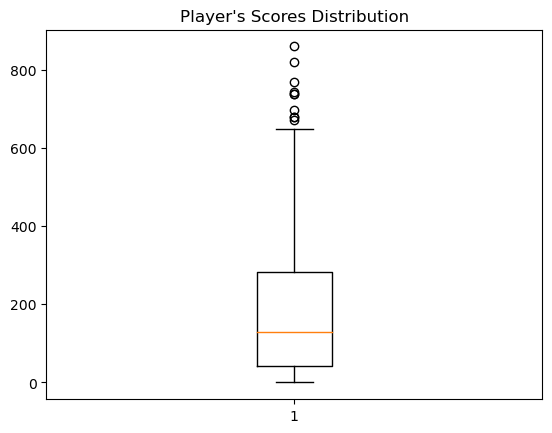

In [160]:
# Outlier Player points

pl_tm['points'] = pd.to_numeric(pl_tm['points'], errors='coerce')

print("Player's Scores Z-Score\n", stats.zscore(pl_tm['points']))
plt.title("Player's Scores Distribution")
plt.boxplot(pl_tm['points'])
plt.show()

In this case, we didn't find it useful to remove the outliers, since they represent players that exceed average measures, as opposed to mistakes in the data collection process.

### Correlation between attributes

In [161]:
def plot_corr_mat(df, name, columns):
    correlation_matrix = df[columns].corr()
    
    plt.figure(figsize=(17, 10))

    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f")
    plt.title(f'Correlation Matrix {name}')
    plt.tight_layout()
    plt.show()


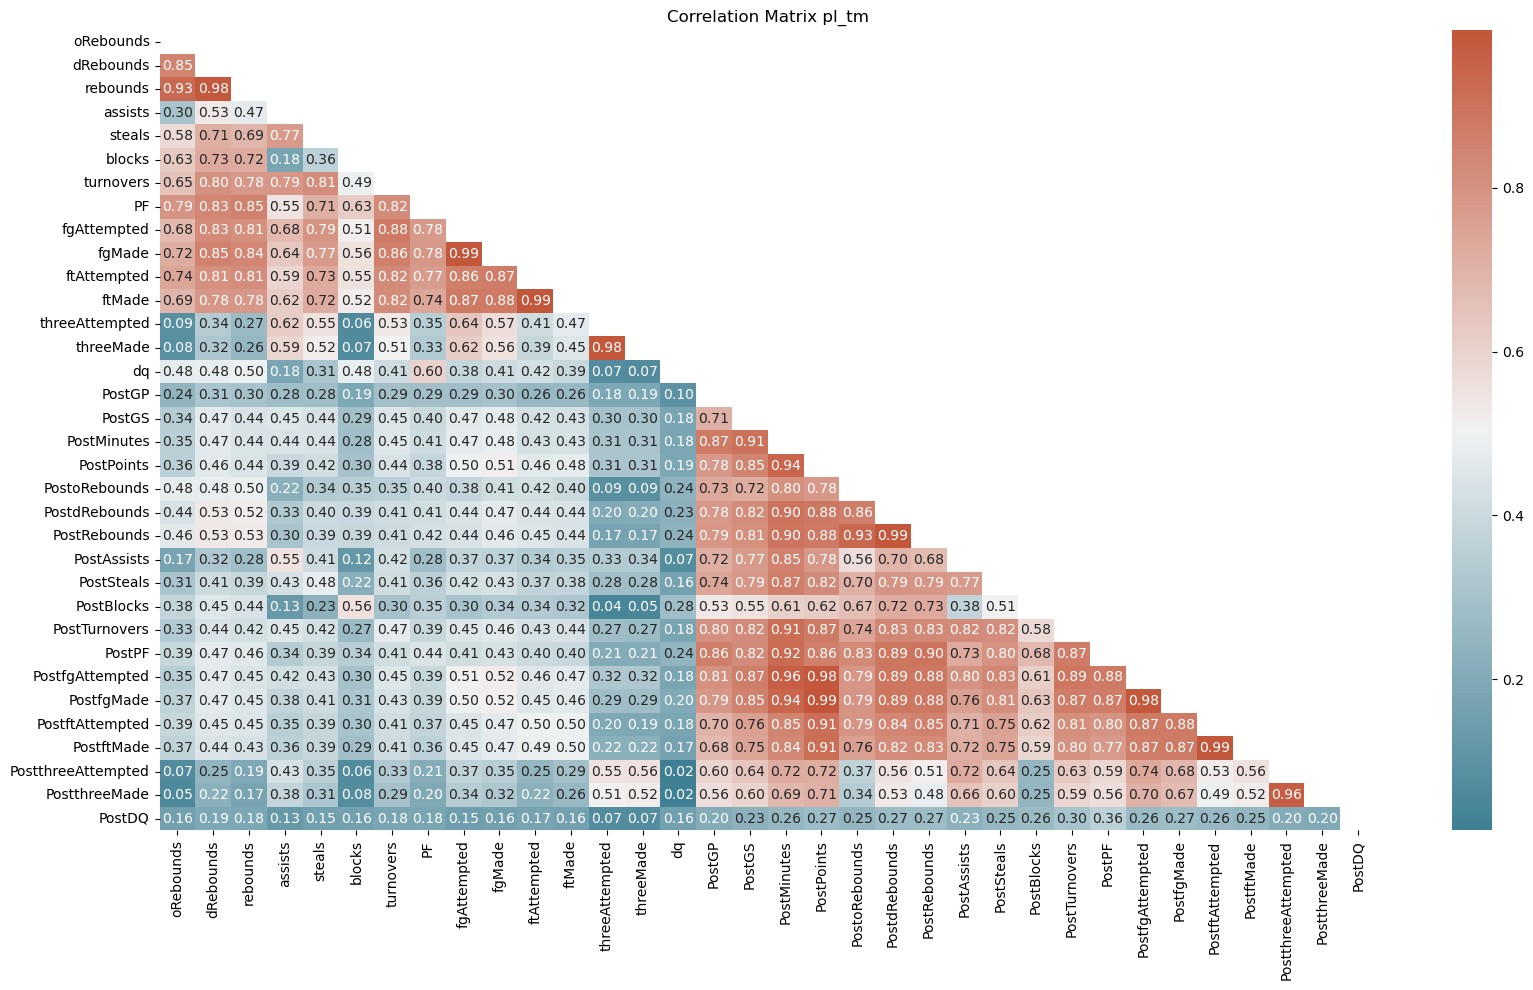

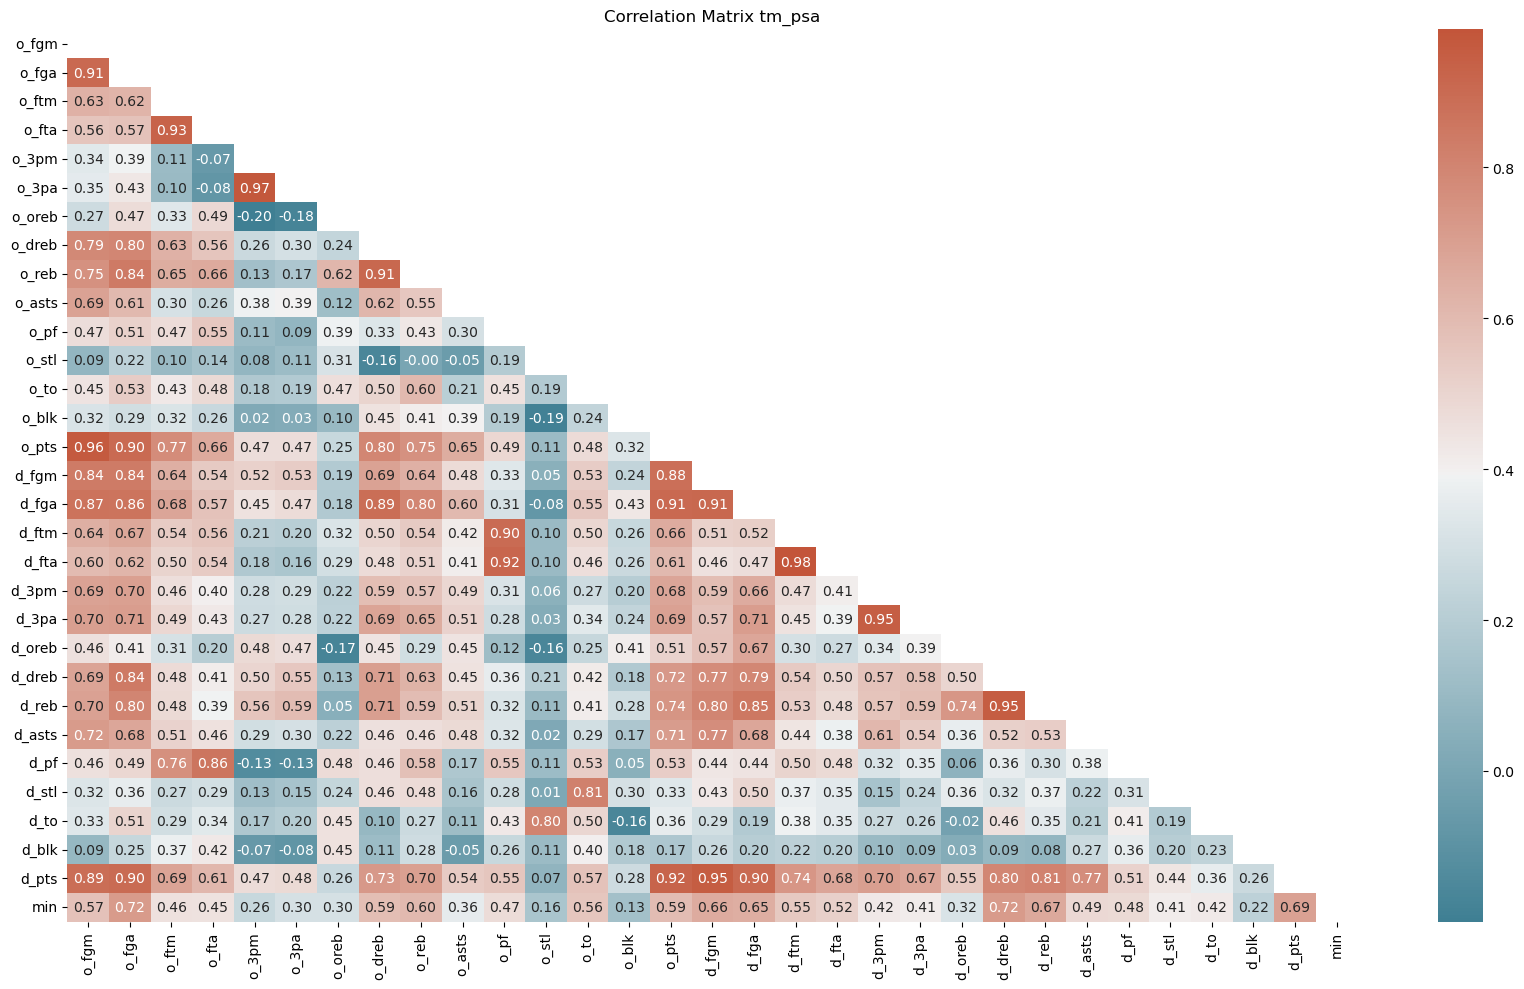

In [162]:
dataframes = [pl_tm, tm_psa]
names = ['pl_tm', 'tm_psa']

selected_columns = [
	[
       'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks',
       'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade',
       'threeAttempted', 'threeMade', 'dq', 'PostGP', 'PostGS', 'PostMinutes',
       'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds',
       'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF',
       'PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade',
       'PostthreeAttempted', 'PostthreeMade', 'PostDQ'],
	
	[ 'o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa',
       'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk',
       'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb',
       'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts',
       'min']
]


for i in range(0, len(dataframes)):
	df = dataframes[i]
	for column in selected_columns[i]:
		if (df[column].dtype == 'object'):  # Check if the column contains strings
			try:
				df[column] = pd.to_numeric(df[column])  # Try to convert to numeric
			except ValueError:
				pass
    
	
	plot_corr_mat(df, names[i], selected_columns[i])

### Sliding Window

In order to accurately predict the following year playoffs qualification, we must analyse the previous year performance. So, we will shift the data one year. This way, data marked from the end of year 1, will be used as learning data for the start of year 2.

In [163]:
pl_aw['year'] = (pl_aw['year'].astype(int) + 1).astype(str)

pl_tm['year'] = (pl_tm['year'].astype(int) + 1).astype(str)

tm_psa['year'] = (tm_psa['year'].astype(int) + 1).astype(str)

cc_tm['year'] = (cc_tm['year'].astype(int) + 1).astype(str)

## Feature Engineering

Create the dataframe, `df`, to be used with the models

In [164]:
df = pd.read_sql_query("SELECT * FROM teams", con)
df['year'] = df['year'].astype(int)
df.sort_values(by=['year'], inplace=True)
df

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,attend,arena
63,1,WNBA,MIA,MIA,EA,,6,N,0,,...,32,9,7,4,12,9,12,6475,127721,AmericanAirlines Arena
24,1,WNBA,DET,DET,EA,,5,N,0,,...,32,8,8,6,10,10,11,6425,107289,The Palace of Auburn Hills
89,1,WNBA,PHO,PHO,WE,,4,Y,0,L,...,32,11,5,9,7,11,10,6425,161075,US Airways Center
129,1,WNBA,UTA,SAS,WE,,5,N,0,,...,32,12,4,6,10,13,8,6400,103442,EnergySolutions Arena
99,1,WNBA,POR,POR,WE,,7,N,0,,...,32,6,10,4,12,4,17,6525,133076,Rose Garden Arena
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,10,WNBA,MIN,MIN,WE,,5,N,0,,...,34,9,8,5,12,7,13,6875,128127,Target Center
85,10,WNBA,NYL,NYL,EA,,7,N,0,,...,34,8,9,5,12,9,13,6900,166604,Madison Square Garden (IV)
98,10,WNBA,PHO,PHO,WE,,1,Y,0,W,...,34,12,5,11,6,13,7,6900,144884,US Airways Center
52,10,WNBA,IND,IND,EA,,1,Y,0,W,...,34,14,3,8,9,17,5,6925,134964,Conseco Fieldhouse


Merge columns with performance data into a single performance indicator

Game Score, applied to the season and to the teams

In [165]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In order for teams with a strong defensive performance to have their strengths represented a "defensive game score", `def_metric_game_score`, is also being calculated and the average of the scores used as the final metric.

In [166]:
for col in ['o_pts', 'o_fgm', 'o_fga', 'o_3pm', 'o_fta', 'o_ftm', 'o_oreb', 'o_dreb', 'o_stl', 'o_asts', 'o_blk', 'o_pf', 'o_to', 'GP']:
    df[col] = df[col].astype(int)

for col in ['d_pts', 'd_fgm', 'd_fga', 'd_3pm', 'd_fta', 'd_ftm', 'd_oreb', 'd_dreb', 'd_stl', 'd_asts', 'd_blk', 'd_pf', 'd_to', 'GP']:
    df[col] = df[col].astype(int)

df['off_metric_game_score'] = (df['o_pts'] + 0.4 * df['o_fgm'] - 0.7 * df['o_fga'] - 0.4 * (df['o_fta'] - df['o_ftm']) + 0.7 * df['o_oreb'] + 0.3 * df['o_dreb'] + df['o_stl'] + 0.7 * df['o_asts'] + 0.7 * df['o_blk'] - 0.4 * df['o_pf'] - df['o_to']) / df['GP']
df['def_metric_game_score'] = (df['d_pts'] + 0.4 * df['d_fgm'] - 0.7 * df['d_fga'] - 0.4 * (df['d_fta'] - df['d_ftm']) + 0.7 * df['d_oreb'] + 0.3 * df['d_dreb'] + df['d_stl'] + 0.7 * df['d_asts'] + 0.7 * df['d_blk'] - 0.4 * df['d_pf'] - df['d_to']) / df['GP']
df['metric_game_score'] = (df['off_metric_game_score'] + df['def_metric_game_score'])/2

print(df.sort_values(by='metric_game_score', ascending=False)['metric_game_score'])

98    66.12
96    62.60
97    62.56
95    61.68
1     57.69
       ... 
120   40.95
64    39.85
119   39.50
14    39.04
63    35.54
Name: metric_game_score, Length: 142, dtype: float64


Effective Field Goal (%) and Free Throw Rate calculation

In [167]:
df['eFG%'] = (df['o_fgm'] + 0.5 * df['o_3pm']) / df['o_fga']
df['FTA_rate'] = df['o_fta'] / df['o_fga']
df.sort_values(by='year', ascending=True)

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,confW,confL,min,attend,arena,off_metric_game_score,def_metric_game_score,metric_game_score,eFG%,FTA_rate
63,1,WNBA,MIA,MIA,EA,,6,N,0,,...,9,12,6475,127721,AmericanAirlines Arena,31.70,39.37,35.54,0.39,0.37
34,1,WNBA,HOU,HOU,WE,,2,Y,0,W,...,17,4,6475,196077,Compaq Center,59.68,38.74,49.21,0.52,0.33
76,1,WNBA,NYL,NYL,EA,,1,Y,0,W,...,14,7,6425,231962,Madison Square Garden (IV),45.84,40.25,43.05,0.47,0.31
2,1,WNBA,CHA,CHA,EA,,8,N,0,,...,5,16,6475,90963,Charlotte Coliseum,44.13,58.80,51.47,0.46,0.30
132,1,WNBA,WAS,WAS,EA,,4,Y,0,L,...,13,8,6400,244134,Verizon Center,47.71,48.99,48.35,0.49,0.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,10,WNBA,CHI,CHI,EA,,5,N,0,,...,10,12,6825,66852,UIC Pavilion,52.21,58.36,55.29,0.48,0.32
1,10,WNBA,ATL,ATL,EA,,2,Y,0,L,...,10,12,6950,120737,Philips Arena,58.00,57.39,57.69,0.47,0.31
52,10,WNBA,IND,IND,EA,,1,Y,0,W,...,17,5,6925,134964,Conseco Fieldhouse,54.41,46.38,50.39,0.45,0.34
111,10,WNBA,SAC,SAC,WE,,6,N,0,,...,6,14,6850,131654,ARCO Arena (II),52.52,55.15,53.83,0.46,0.34


Game Score, applied to the season and to the players

In [168]:
for col in ['points', 'fgMade', 'fgAttempted', 'ftAttempted', 'ftMade', 'oRebounds', 'dRebounds', 'steals', 'assists', 'blocks', 'PF', 'turnovers', 'GP']:
    pl_tm[col] = pl_tm[col].astype(int)

pl_tm['off_metric_game_score'] = (pl_tm['points'] + 0.4 * pl_tm['fgMade'] - 0.7 * pl_tm['fgAttempted'] - 0.4 * (pl_tm['ftAttempted'] - pl_tm['ftMade']) + 0.7 * pl_tm['oRebounds'] + 0.3 * pl_tm['dRebounds'] + pl_tm['steals'] + 0.7 * pl_tm['assists'] + 0.7 * pl_tm['blocks'] - 0.4 * pl_tm['PF'] - pl_tm['turnovers']) / pl_tm['GP']
print(pl_tm.sort_values(by='off_metric_game_score', ascending=False)['off_metric_game_score'])

mean_gs = pl_tm.groupby(['tmID', 'year'])["off_metric_game_score"].mean().reset_index().sort_values(by='off_metric_game_score', ascending=False)

for idx, x in mean_gs.iterrows():
    year_condition = df['year'] == int(x['year'])
    tmID_condition = df['tmID'] == str(x['tmID'])
    df.loc[year_condition & tmID_condition, "mean_player_game_score"] = x['off_metric_game_score']

df

736    19.90
1576   17.77
1589   17.56
1587   17.26
735    17.21
        ... 
56     -1.90
287    -2.00
1663   -2.10
1612   -2.50
1141   -2.60
Name: off_metric_game_score, Length: 1876, dtype: float64


,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,confL,min,attend,arena,off_metric_game_score,def_metric_game_score,metric_game_score,eFG%,FTA_rate,mean_player_game_score
63,1,WNBA,MIA,MIA,EA,,6,N,0,,...,12,6475,127721,AmericanAirlines Arena,31.70,39.37,35.54,0.39,0.37,NaN
24,1,WNBA,DET,DET,EA,,5,N,0,,...,11,6425,107289,The Palace of Auburn Hills,47.36,53.15,50.25,0.46,0.35,NaN
89,1,WNBA,PHO,PHO,WE,,4,Y,0,L,...,10,6425,161075,US Airways Center,50.51,41.00,45.76,0.48,0.37,NaN
129,1,WNBA,UTA,SAS,WE,,5,N,0,,...,8,6400,103442,EnergySolutions Arena,52.68,53.51,53.10,0.48,0.42,NaN
99,1,WNBA,POR,POR,WE,,7,N,0,,...,17,6525,133076,Rose Garden Arena,39.67,48.27,43.97,0.46,0.38,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,10,WNBA,MIN,MIN,WE,,5,N,0,,...,13,6875,128127,Target Center,55.10,59.21,57.15,0.47,0.34,4.33
85,10,WNBA,NYL,NYL,EA,,7,N,0,,...,13,6900,166604,Madison Square Garden (IV),49.19,50.99,50.09,0.47,0.27,4.58
98,10,WNBA,PHO,PHO,WE,,1,Y,0,W,...,7,6900,144884,US Airways Center,67.93,64.31,66.12,0.51,0.31,5.00
52,10,WNBA,IND,IND,EA,,1,Y,0,W,...,5,6925,134964,Conseco Fieldhouse,54.41,46.38,50.39,0.45,0.34,3.71


Create an award score for each `team-year` occurence based on the award enconding previously employed

In [169]:
team_player_award_score = pl_aw.groupby(['tmID', 'year'])['award_score'].sum().reset_index()
team_coach_award_score = cc_aw.groupby(['tmID', 'year'])['award_score'].sum().reset_index()

df['award_score'] = 0

for idx, x in team_player_award_score.iterrows():
    year_condition = df['year'] == int(x['year'])
    tmID_condition = df['tmID'] == str(x['tmID'])
    df.loc[year_condition & tmID_condition, "award_score"] += x['award_score']

for idx, x in team_coach_award_score.iterrows():
    year_condition = df['year'] == int(x['year'])
    tmID_condition = df['tmID'] == str(x['tmID'])
    df.loc[year_condition & tmID_condition, "award_score"] += x['award_score']

df

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,min,attend,arena,off_metric_game_score,def_metric_game_score,metric_game_score,eFG%,FTA_rate,mean_player_game_score,award_score
63,1,WNBA,MIA,MIA,EA,,6,N,0,,...,6475,127721,AmericanAirlines Arena,31.70,39.37,35.54,0.39,0.37,NaN,0
24,1,WNBA,DET,DET,EA,,5,N,0,,...,6425,107289,The Palace of Auburn Hills,47.36,53.15,50.25,0.46,0.35,NaN,0
89,1,WNBA,PHO,PHO,WE,,4,Y,0,L,...,6425,161075,US Airways Center,50.51,41.00,45.76,0.48,0.37,NaN,0
129,1,WNBA,UTA,SAS,WE,,5,N,0,,...,6400,103442,EnergySolutions Arena,52.68,53.51,53.10,0.48,0.42,NaN,0
99,1,WNBA,POR,POR,WE,,7,N,0,,...,6525,133076,Rose Garden Arena,39.67,48.27,43.97,0.46,0.38,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,10,WNBA,MIN,MIN,WE,,5,N,0,,...,6875,128127,Target Center,55.10,59.21,57.15,0.47,0.34,4.33,7
85,10,WNBA,NYL,NYL,EA,,7,N,0,,...,6900,166604,Madison Square Garden (IV),49.19,50.99,50.09,0.47,0.27,4.58,0
98,10,WNBA,PHO,PHO,WE,,1,Y,0,W,...,6900,144884,US Airways Center,67.93,64.31,66.12,0.51,0.31,5.00,0
52,10,WNBA,IND,IND,EA,,1,Y,0,W,...,6925,134964,Conseco Fieldhouse,54.41,46.38,50.39,0.45,0.34,3.71,8


In [170]:
pt['year'] = pt['year'].astype(int)
pt.sort_values(by=['year'], inplace=True)
grouped = pt.groupby(['tmID', 'year'])[['tmID', 'playerID', 'year']]
teams_dict = {}
res_dict = {}

for name, group in grouped:
    loop_df = pd.DataFrame(group)
    if name[0] in teams_dict.keys():
        teams_dict[name[0]][name[1]] = loop_df['playerID'].unique().tolist()
    else:
        teams_dict[name[0]] = {}
        teams_dict[name[0]][name[1]] = loop_df['playerID'].unique().tolist()

for x in teams_dict.keys():
    prev = None
    if len(teams_dict[x].keys()) == 1:
        res_dict[x][teams_dict[x].keys()[0]] = 0
        continue
    for y in teams_dict[x].keys():
        if prev == None: 
            prev = y
            res_dict[x] = {}
            res_dict[x][y] = 0
            continue

        past = teams_dict[x][prev]
        present = teams_dict[x][y]
        prev = y
        count = 0

        for player in past:
            if player in present:
                count += 1

        # ratio of players that stayed
        count /= len(present)

        res_dict[x][y] = {}
        res_dict[x][y] = round(count,2)


for key in res_dict.keys():
    for year in res_dict[key].keys():
        year_condition = df['year'] == int(year)
        tmID_condition = df['tmID'] == str(key)
        df.loc[year_condition & tmID_condition, "player_retention"] = res_dict[key][year]

df

,year,lgID,tmID,franchID,confID,divID,rank,playoff,seeded,firstRound,...,attend,arena,off_metric_game_score,def_metric_game_score,metric_game_score,eFG%,FTA_rate,mean_player_game_score,award_score,player_retention
63,1,WNBA,MIA,MIA,EA,,6,N,0,,...,127721,AmericanAirlines Arena,31.70,39.37,35.54,0.39,0.37,NaN,0,0.00
24,1,WNBA,DET,DET,EA,,5,N,0,,...,107289,The Palace of Auburn Hills,47.36,53.15,50.25,0.46,0.35,NaN,0,0.00
89,1,WNBA,PHO,PHO,WE,,4,Y,0,L,...,161075,US Airways Center,50.51,41.00,45.76,0.48,0.37,NaN,0,0.00
129,1,WNBA,UTA,SAS,WE,,5,N,0,,...,103442,EnergySolutions Arena,52.68,53.51,53.10,0.48,0.42,NaN,0,0.00
99,1,WNBA,POR,POR,WE,,7,N,0,,...,133076,Rose Garden Arena,39.67,48.27,43.97,0.46,0.38,NaN,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,10,WNBA,MIN,MIN,WE,,5,N,0,,...,128127,Target Center,55.10,59.21,57.15,0.47,0.34,4.33,7,0.31
85,10,WNBA,NYL,NYL,EA,,7,N,0,,...,166604,Madison Square Garden (IV),49.19,50.99,50.09,0.47,0.27,4.58,0,0.82
98,10,WNBA,PHO,PHO,WE,,1,Y,0,W,...,144884,US Airways Center,67.93,64.31,66.12,0.51,0.31,5.00,0,0.58
52,10,WNBA,IND,IND,EA,,1,Y,0,W,...,134964,Conseco Fieldhouse,54.41,46.38,50.39,0.45,0.34,3.71,8,0.43


## Creating and training the model

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score

### Decision Tree Classifier

In [172]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

df["playoff"].replace({"N": 0, "Y": 1}, inplace=True)

model = DecisionTreeClassifier(random_state=48)

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "def_metric_game_score", "metric_game_score"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False, random_state=48)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

dt_acc = accuracy_score(y_test, y_prediction)
dt_prec = precision_score(y_test, y_prediction)
dt_f1 = f1_score(y_test, y_prediction)

print(dt_acc)
print(dt_prec)
print(dt_f1)

[print(f"{trained_model.feature_names_in_[idx]}: {round(x*100, 2)}%") for idx, x in enumerate(trained_model.feature_importances_)]


0.7777777777777778
0.8125
0.8125
def_metric_game_score: 53.26%
metric_game_score: 46.74%


[None, None]

### Naive Bayes Gaussian and Mulitnomial

In [173]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

model = GaussianNB()

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "off_metric_game_score", "eFG%", "FTA_rate", "def_metric_game_score", "award_score"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False, random_state=48)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

nbg_acc = accuracy_score(y_test, y_prediction)
nbg_prec = precision_score(y_test, y_prediction)
nbg_f1 = f1_score(y_test, y_prediction)

print(nbg_acc)
print(nbg_prec)
print(nbg_f1)
print()
model = MultinomialNB()

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "metric_game_score", "def_metric_game_score"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False, random_state=48)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

nbm_acc = accuracy_score(y_test, y_prediction)
nbm_prec = precision_score(y_test, y_prediction)
nbm_f1 = f1_score(y_test, y_prediction)

print(nbm_acc)
print(nbm_prec)
print(nbm_f1)

# [print(f"{trained_model.feature_names_in_[idx]}: {x}") for idx, x in enumerate(trained_model.feature_importances_)]

0.8518518518518519
0.875
0.875

0.6666666666666666
0.64
0.7804878048780487


### K-Nearest Neighbors

In [174]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "off_metric_game_score", "def_metric_game_score"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False, random_state=48)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

knn_acc = accuracy_score(y_test, y_prediction)
knn_prec = precision_score(y_test, y_prediction)
knn_f1 = f1_score(y_test, y_prediction)

print(knn_acc)
print(knn_prec)
print(knn_f1)


0.7777777777777778
0.7777777777777778
0.823529411764706


### Random Forest

In [175]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=48)

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "metric_game_score", "eFG%", "def_metric_game_score", "award_score"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False, random_state=48)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

rf_acc = accuracy_score(y_test, y_prediction)
rf_prec = precision_score(y_test, y_prediction)
rf_f1 = f1_score(y_test, y_prediction)

print(rf_acc)
print(rf_prec)
print(rf_f1)


0.8518518518518519
0.9285714285714286
0.8666666666666666


### Logistic Regression

In [176]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000, random_state=48)

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "off_metric_game_score", "eFG%", "d_fgm","d_fga","d_ftm","d_fta","d_3pm","d_3pa","d_oreb","d_dreb","d_reb","d_asts","d_pf","d_stl","d_to","d_blk","d_pts"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False, random_state=48)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

lr_acc = accuracy_score(y_test, y_prediction)
lr_prec = precision_score(y_test, y_prediction)
lr_f1 = f1_score(y_test, y_prediction)

print(lr_acc)
print(lr_prec)
print(lr_f1)


0.8148148148148148
0.9230769230769231
0.8275862068965517


### Support Vector Machines

In [177]:
from sklearn.svm import SVC

model = SVC(random_state=48)

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "off_metric_game_score", "def_metric_game_score"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False, random_state=48)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

svc_acc = accuracy_score(y_test, y_prediction)
svc_prec = precision_score(y_test, y_prediction)
svc_f1 = f1_score(y_test, y_prediction)

print(svc_acc)
print(svc_prec)
print(svc_f1)


0.8148148148148148
0.8235294117647058
0.8484848484848485


### Gradient Boosted Trees

In [178]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

X_file, Y_file = df.drop("playoff", axis=1), df["playoff"]

for column in df.columns:
    if (column not in ["playoff", "metric_game_score", "def_metric_game_score"]):
        X_file.drop(column, axis=1, inplace=True)

# Fit the model to the training data
x_train, x_test, y_train, y_test = train_test_split(X_file, Y_file, test_size=0.19, shuffle=False)
trained_model = model.fit(x_train, y_train)

# Predict using the trained model
y_prediction = trained_model.predict(x_test)

gbt_acc = accuracy_score(y_test, y_prediction)
gbt_prec = precision_score(y_test, y_prediction)
gbt_f1 = f1_score(y_test, y_prediction)

print(gbt_acc)
print(gbt_prec)
print(gbt_f1)

[print(f"{trained_model.feature_names_in_[idx]}: {x}") for idx, x in enumerate(trained_model.feature_importances_)]


0.7777777777777778
0.8125
0.8125
def_metric_game_score: 0.6356968583535699
metric_game_score: 0.36430314164643


[None, None]

## Model Comparison

In [179]:
dt_dict = {'Accuracy': dt_acc,
            'Precision': dt_prec,
            'F1': dt_f1}

nbg_dict = {'Accuracy': nbg_acc,
            'Precision': nbg_prec,
            'F1': nbg_f1}

nbm_dict = {'Accuracy': nbm_acc,
            'Precision': nbm_prec,
            'F1': nbm_f1}

knn_dict = {'Accuracy': knn_acc,
            'Precision': knn_prec,
            'F1': knn_f1}

rf_dict = {'Accuracy': rf_acc,
            'Precision': rf_prec,
            'F1': rf_f1}

lr_dict = {'Accuracy': lr_acc,
            'Precision': lr_prec,
            'F1': lr_f1}

svc_dict = {'Accuracy': svc_acc,
            'Precision': svc_prec,
            'F1': svc_f1}

gbt_dict = {'Accuracy': gbt_acc,
            'Precision': gbt_prec,
            'F1': gbt_f1}

comparison = pd.DataFrame({'Decision Tree': pd.Series(dt_dict),
                       'Gaussian Naive Bayes': pd.Series(nbg_dict),
                       'Multinomial Naive Bayes': pd.Series(nbm_dict),
                       'K-Nearest Neighbors': pd.Series(knn_dict),
                       'Random Forest': pd.Series(rf_dict),
                       'Logistic Regression': pd.Series(lr_dict),
                       'Support Vector Machines': pd.Series(svc_dict),
                       'Gradient Boosted Trees': pd.Series(gbt_dict),
                      })
comparison

,Decision Tree,Gaussian Naive Bayes,Multinomial Naive Bayes,K-Nearest Neighbors,Random Forest,Logistic Regression,Support Vector Machines,Gradient Boosted Trees
Accuracy,0.78,0.85,0.67,0.78,0.85,0.81,0.81,0.78
Precision,0.81,0.88,0.64,0.78,0.93,0.92,0.82,0.81
F1,0.81,0.88,0.78,0.82,0.87,0.83,0.85,0.81
